In [1]:
from os.path import isdir

from helpers.helpers import get_checkpoint_name_and_checkpoint_path
from helpers.embeddings import load_embeddings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scienceplots
plt.style.use('science')

# FONTS
import sys
from os.path import abspath
source_path = abspath('..')
if not source_path in sys.path:
    sys.path.append(source_path)
from font import SETTINGS
for key in SETTINGS:
    plt.rc(key, **SETTINGS[key])

nanogpt_path = abspath('../nanoGPT')
if not nanogpt_path in sys.path:
    sys.path.append(nanogpt_path)

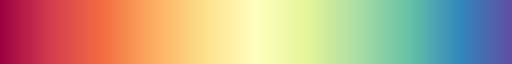

In [2]:
_cmap = plt.get_cmap('Spectral')
_cmap

In [3]:
cmap = _cmap(np.linspace(1, 0, 10)) # start with blue, end with red
len(cmap)

10

In [4]:
COLOR = plt.rcParams['axes.prop_cycle']
COLOR = [v for elem in list(COLOR) for _, v in elem.items()]
COLOR

['#0C5DA5', '#00B945', '#FF9500', '#FF2C00', '#845B97', '#474747', '#9e9e9e']

In [5]:
FIGURE_FORMAT = 'pdf'
# FIGURE_FORMAT = 'png'

In [6]:
CHECKPOINT_DIRECTORY = '../checkpoints'
assert isdir(CHECKPOINT_DIRECTORY)

In [7]:
POSITIONS = ['output']

# 0. Get Checkpoint

In [8]:
N = '4'
D = 0
VARIANT = 'A'
GAMMA = '0e+00'
LR = 'lr10-'
CHECKPOINT = 'ckpt_100000'

In [9]:
checkpoint_name, checkpoint_path = get_checkpoint_name_and_checkpoint_path(CHECKPOINT_DIRECTORY, N, D, VARIANT, LR, GAMMA, CHECKPOINT)
checkpoint_name, checkpoint_path

('wor40A-16M-13p1B-100k-bs64-lr10-baseline-g0e+00-s1',
 '../checkpoints/wor40A-16M-13p1B-100k-bs64-lr10-baseline-g0e+00-s1/ckpt_100000.pt')

# 1. Load Embeddings & Final Hidden States

### a. Embeddings

In [10]:
OVERWRITE = False

In [11]:
embeddings = load_embeddings(
    checkpoint_path, 
    checkpoint_name, 
    positions=POSITIONS, 
    overwrite=OVERWRITE,
)

> loaded embeddings for wor40A-16M-13p1B-100k-bs64-lr10-baseline-g0e+00-s1
.. position = output, embeddings[position].shape = (50304, 224)


# 2. Analyze Embeddings & Final Hidden States

### a. Embeddings

In [12]:
embeddings.keys()

dict_keys(['output'])

In [13]:
E = embeddings['output']
E.shape

(50304, 224)

In [14]:
mu = np.mean(E, axis=0, keepdims=True).T
musq = (mu.T @ mu)[0, 0]
musq

np.float32(4.894086)

### dots

In [15]:
dots = (E @ mu)[:, 0]
dots.shape

(50304,)

In [16]:
np.min(dots), np.max(dots)

(np.float32(-2.9141207), np.float32(9.550041))

In [17]:
B_plus = np.max(dots) - musq
B_plus

np.float32(4.6559553)

In [18]:
B_minus = musq - np.min(dots)
- B_minus

np.float32(-7.8082066)

mu**2 = 4.89
B_plus = 4.66
=> (mean_embedding)**2 + B_plus = 9.55
B_minus = 7.81
=> B_ratio = 0.82
> saved as figs/dot_product_histogram_40A-lr10--gamma0e+00-ckpt_100000.pdf


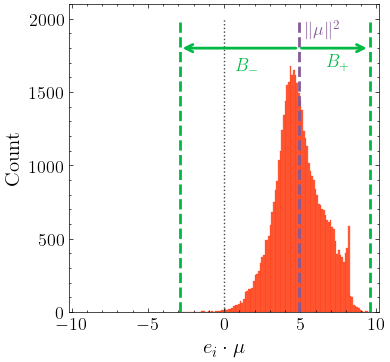

In [19]:
def plot_histogram(_dots, _musq, _B_plus, _B_minus, save_as=''):

    COLOR_ZERO = COLOR[-2]
    COLOR_BOUND = COLOR[1]
    COLOR_HIST = COLOR[3]
    COLOR_MEAN = COLOR[4]
    
    _, ax = plt.subplots(1, 1, figsize=(4,4))
    ax = [ax, None]
    
    df = pd.DataFrame.from_dict({'dot product': _dots})
    _ = sns.histplot(x=df['dot product'], ax=ax[0], color=COLOR_HIST, edgecolor=COLOR_HIST)
    _ = ax[0].set_xlabel(r'$e_i \cdot \mu$')
    _ = ax[0].plot([0, 0], [0, 2000], marker='', linestyle=':', color=COLOR_ZERO)
    _ = ax[0].plot([_musq, _musq], [0, 2000], marker='', linestyle='--', linewidth=2, color=COLOR_MEAN)
    _ = ax[0].plot([_musq+_B_plus, _musq+_B_plus], [0, 2000], marker='', linestyle='--', linewidth=2, color=COLOR_BOUND)
    _ = ax[0].plot([_musq-_B_minus, _musq-_B_minus], [0, 2000], marker='', linestyle='--', linewidth=2, color=COLOR_BOUND)
    xlim = ax[0].get_xlim()
    xlim_new = max(xlim)
    _ = ax[0].set_xlim([-xlim_new, xlim_new])
    
    # print
    print(f'mu**2 = {_musq:.2f}')
    print(f'B_plus = {_B_plus:.2f}')
    print(f'=> (mean_embedding)**2 + B_plus = {_musq+_B_plus:.2f}')
    print(f'B_minus = {_B_minus:.2f}')
    _B_ratio = np.max((_B_minus, _B_plus)) / np.max((_B_minus - _musq, _B_plus + _musq))
    print(f'=> B_ratio = {_B_ratio:.2f}')

    _ = ax[0].annotate("", xytext=(_musq, 1800), xy=(_musq + _B_plus, 1800), arrowprops=dict(arrowstyle="->", linewidth=2, color=COLOR_BOUND))
    _ = ax[0].annotate("", xytext=(_musq, 1800), xy=(_musq - _B_minus, 1800), arrowprops=dict(arrowstyle="->", linewidth=2, color=COLOR_BOUND))
    _ = ax[0].text(_B_plus + 2, 1670, r'$B_+$', color=COLOR_BOUND)
    _ = ax[0].text(-_B_minus + 8.5, 1670, r'$B_-$', color=COLOR_BOUND)
    _ = ax[0].text(_musq + 0.5, 1890, r'$\| \mu \|^2$', color=COLOR_MEAN)

    if len(save_as):
        assert save_as.endswith('.pdf') or save_as.endswith('.png')
        fig_path = f'figs/{save_as}'
        plt.savefig(fig_path, format=save_as[-3:], bbox_inches='tight')
        print(f'> saved as {fig_path}')

plot_histogram(dots, musq, B_plus, B_minus, save_as=f'dot_product_histogram_{N}{D}{VARIANT}-{LR}-gamma{GAMMA}-{CHECKPOINT}.{FIGURE_FORMAT}')